## 基于SVM分类器的人脸识别--PCA、NFM、LDA三种特征抓取方法比较

### 一、图片数据提取

#### Step1：遍历取出所有的图片文件

In [1]:
##将文件下所有的文件（包括子文件夹下的文件）
import os
def list_all_files(rootdir):        
    _files = []    
    list = os.listdir(rootdir) #列出文件夹下所有的目录与文件    
    for i in range(0,len(list)):           
        path = os.path.join(rootdir,list[i])           
        if os.path.isdir(path):      
            _files.extend(list_all_files(path))          
        if os.path.isfile(path):              
            _files.append(path)    
    return _files
fs = list_all_files('C:/python/Python Computer Version/FaceDB/database')

In [2]:
fs

['C:/python/Python Computer Version/FaceDB/database\\1\\MAVICA.HTM',
 'C:/python/Python Computer Version/FaceDB/database\\1\\MVC-001F.JPG',
 'C:/python/Python Computer Version/FaceDB/database\\1\\MVC-002F.JPG',
 'C:/python/Python Computer Version/FaceDB/database\\1\\MVC-003F.JPG',
 'C:/python/Python Computer Version/FaceDB/database\\1\\MVC-004F.JPG',
 'C:/python/Python Computer Version/FaceDB/database\\1\\MVC-005F.JPG',
 'C:/python/Python Computer Version/FaceDB/database\\1\\MVC-006F.JPG',
 'C:/python/Python Computer Version/FaceDB/database\\1\\MVC-007F.JPG',
 'C:/python/Python Computer Version/FaceDB/database\\10\\MAVICA.HTM',
 'C:/python/Python Computer Version/FaceDB/database\\10\\MVC-001F.JPG',
 'C:/python/Python Computer Version/FaceDB/database\\10\\MVC-002F.JPG',
 'C:/python/Python Computer Version/FaceDB/database\\10\\MVC-003F.JPG',
 'C:/python/Python Computer Version/FaceDB/database\\10\\MVC-004F.JPG',
 'C:/python/Python Computer Version/FaceDB/database\\10\\MVC-005F.JPG',
 'C:

#### Step2：得到每一个图片的类别（文件夹名称）

In [6]:
Y=[]
for i in range(1,len(fs)):
    if fs[i].endswith('.JPG'):
        a=fs[i].partition('\\')
        b=a[2].partition('\\')
        y=b[0]
        Y.append(y)
print(Y[0:10])

['1', '1', '1', '1', '1', '1', '1', '10', '10', '10']


#### Step3：处理图片

In [72]:
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image
data1=[]
for i in range(1,len(fs)):
    if fs[i].endswith('.JPG'):
        filename = fs[i]
        im = Image.open(filename) 
        im = im.resize((80,60))##为了加快速度，将640*480像素图片模糊到80*60像素
        width,height = im.size
        im = im.convert("L") ##灰度
        picdata = im.getdata()
        picdata = list(picdata)
        data1.append(picdata)
data1 = np.matrix(data1,'float')/255.0##归一化处理

In [73]:
print(data1)##得到的data1，每一行是一张图片，每一个值是像素块的灰度

[[0.67843137 0.67843137 0.69019608 ... 0.65098039 0.64313725 0.63529412]
 [0.63921569 0.63921569 0.65490196 ... 0.59215686 0.59215686 0.58039216]
 [0.63137255 0.63137255 0.64313725 ... 0.59215686 0.57254902 0.57254902]
 ...
 [0.65098039 0.64705882 0.6627451  ... 0.64313725 0.63137255 0.61568627]
 [0.63921569 0.63529412 0.65098039 ... 0.61960784 0.60392157 0.60392157]
 [0.63921569 0.65490196 0.65882353 ... 0.62352941 0.60784314 0.60392157]]


In [74]:
im.size

(80, 60)

In [75]:
data1.shape

(797, 4800)

### 二、构建SVM分类器

### （一）基于PCA方法的全部图片集

#### Step1：拆分训练集和测试集

In [252]:
X=data1
from sklearn.model_selection import train_test_split
# 拆分训练集和测试集
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15,random_state=15)

#### Step2：用PCA方法降维（进行特征抽取）

In [287]:
##现在需要降维 
##用PCA
from sklearn.decomposition import PCA
import time
n_components = 36##选36个主成分
t0 = time.time()
pca = PCA(n_components=n_components, whiten=True).fit(X_train)
print("pca done %0.3fs" % (time.time() - t0))

t0 = time.time()
X_train_pca = pca.transform(X_train)##得到X_train的特征值
X_test_pca  = pca.transform(X_test)##得到X_test的特征值
print("data set to pca done %0.3fs" % (time.time() - t0))

pca done 0.281s
data set to pca done 0.031s


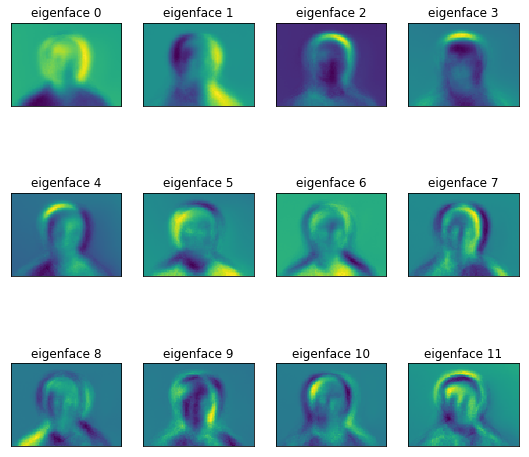

In [288]:
##得到特征脸并画图
eigenfaces = pca.components_.reshape((n_components, height, width))
eigenfaces.shape
def plot_gallery(images,titles,h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)))
        plt.title(titles[i], size=12)  
        plt.xticks(())
        plt.yticks(())
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]        
plot_gallery(eigenfaces,eigenface_titles,h=height, w=width)        

#### Step3：训练SVM分类器

In [82]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

# 构造分类器
t0 = time.time()
param_grid = {
    "C": [1e3, 5e3, 1e4, 1e5],
    "gamma": [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]
}

clf = GridSearchCV(svm.SVC(kernel='rbf', class_weight='balanced'), param_grid=param_grid)
clf.fit(X_train_pca, Y_train)
print("fit done %0.3fs" % (time.time() - t0))
print(clf.best_estimator_)##输出最优的训练模型
print(clf.best_score_)##输出训练模型的识别度

fit done 10.220s
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.24224519940915806


注：param_grid 参数
>C 是一个对错误的部分的惩罚；                                                                                    
>gamma 对于不同的核函数会有不同的表现，gamma 表示使用多少比例的特征点；                                          
>因为我们不知道哪些参数会产生最好的结果，因此使用不同的参数来训练，然后选取训练最好的模型；                      
>因此使用不同值的 C 和不同值的 gamma ，进行多次尝试，然后进行搜索，选出准确率最高的模型                          
 即clf.best_estimator_。

#### Step4：用训练出的模型对test部分进行预测

In [83]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# 预测
y_pred = clf.predict(X_test_pca)
print(classification_report(Y_test, y_pred))
##有33%的准确率

             precision    recall  f1-score   support

          1       1.00      1.00      1.00         1
         10       0.00      0.00      0.00         0
        100       0.00      0.00      0.00         1
        101       0.00      0.00      0.00         0
        102       0.00      0.00      0.00         0
        103       0.67      1.00      0.80         2
        104       0.00      0.00      0.00         1
        105       0.00      0.00      0.00         1
        106       0.50      1.00      0.67         1
        107       0.00      0.00      0.00         2
        108       1.00      1.00      1.00         1
        109       0.00      0.00      0.00         1
         11       0.00      0.00      0.00         1
        110       0.33      1.00      0.50         1
        111       1.00      1.00      1.00         2
        113       0.00      0.00      0.00         1
        114       1.00      1.00      1.00         2
         13       0.33      1.00      0.50   

C:\Users\zhoumeng\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\zhoumeng\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


#### Step4：结果可视化

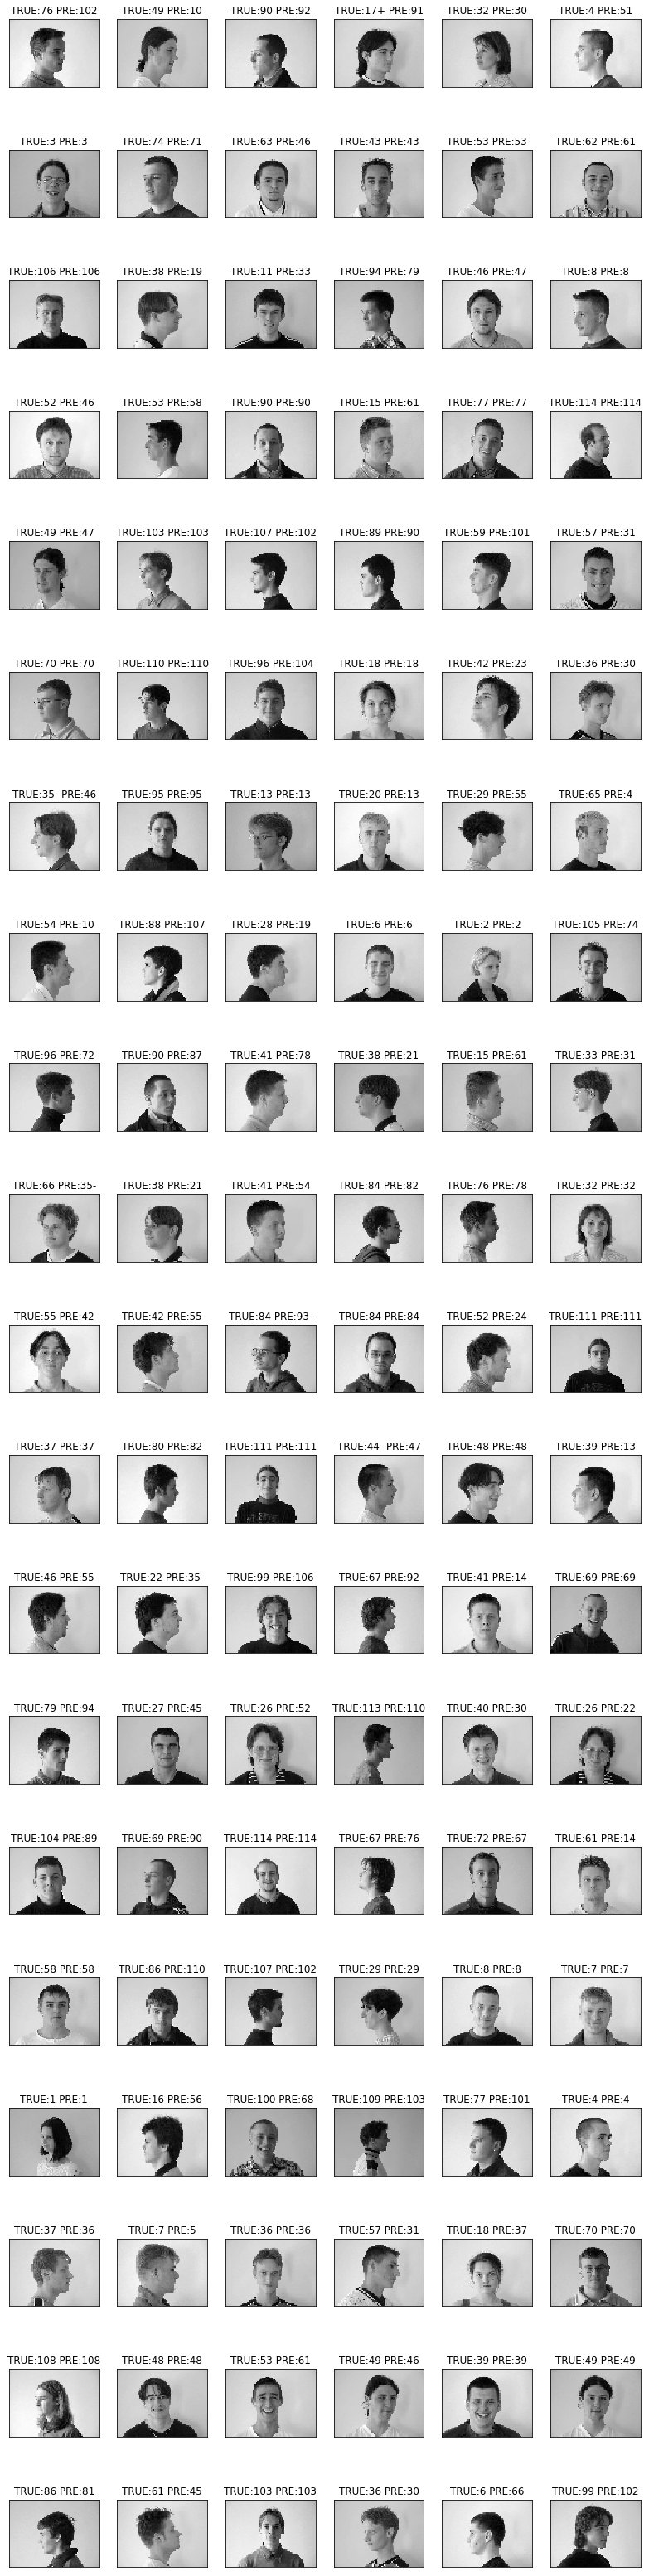

In [84]:
import matplotlib.pyplot as plt
def plot_gallery(images,h, w, n_row=20, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title("TRUE:"+Y_test[i]+" "+"PRE:"+y_pred[i], size=12)
        plt.xticks(())
        plt.yticks(())
plot_gallery(X_test,h=height, w=width)


考虑为什么识别率低的原因可能是由于整个图片集合既有正脸图片又有侧脸图片，而正脸和侧脸的差距很大，所以可能会导致识别率很低，同时观察可视化结果发现，确实测试集中的正脸被识别正确的概率更大

### （二）、基于PCA方法的正脸图片集

#### Step1：重新筛选数据集

In [85]:
##准确度比较低
##感觉因为既有正脸又有侧脸，应该很难匹配，所以考虑重新选择照片
##我只挑选含有正脸的照片作为数据集
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image
data2=[]
for i in range(1,len(fs)):
    if fs[i].endswith('MVC-003F.JPG')or fs[i].endswith('MVC-006F.JPG')or fs[i].endswith('MVC-007F.JPG'):
        filename = fs[i]
        im = Image.open(filename) 
        im = im.resize((80,60))
        width,height = im.size
        im = im.convert("L") 
        picdata = im.getdata()
        picdata = list(picdata)
        data2.append(picdata)
data2 = np.matrix(data2,'float')/255.0##归一化处理

In [86]:
print(data2.shape)##有336张图片

(336, 4800)


In [87]:
Y1=[]
for i in range(1,len(fs)):
    if fs[i].endswith('MVC-003F.JPG')or fs[i].endswith('MVC-006F.JPG')or fs[i].endswith('MVC-007F.JPG'):
        a=fs[i].partition('\\')
        b=a[2].partition('\\')
        y=b[0]
        Y1.append(y)

#### Step2：拆分训练集和测试集

In [88]:
X1=data2
from sklearn.model_selection import train_test_split
# 拆分训练集和测试集
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size=0.25,random_state=15)##扩大了测试集的比例

#### Step3：用PCA方法降维（进行特征抽取）

In [89]:
##用PCA
from sklearn.decomposition import PCA
import time
n_components = 36 ##降到36维
t0 = time.time()
pca = PCA(n_components=n_components, whiten=True).fit(X1_train)
print("pca done %0.3fs" % (time.time() - t0))

t0 = time.time()
X1_train_pca = pca.transform(X1_train)
X1_test_pca  = pca.transform(X1_test)
print("data set to pca done %0.3fs" % (time.time() - t0))

pca done 0.124s
data set to pca done 0.022s


In [90]:
eigenfaces = pca.components_.reshape((n_components, height, width))
eigenfaces.shape

(36, 60, 80)

#### Step4：训练SVM分类器

In [91]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

# 构造分类器
t0 = time.time()
param_grid = {
    "C": [1e3, 5e3, 1e4, 1e5],
    "gamma": [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]
}

clf = GridSearchCV(svm.SVC(kernel='rbf', class_weight='balanced'), param_grid=param_grid)
clf.fit(X1_train_pca, Y1_train)
print("fit done %0.3fs" % (time.time() - t0))
print(clf.best_estimator_)
print(clf.best_score_)

C:\Users\zhoumeng\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


fit done 3.091s
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.4087301587301587


#### Step5：用训练出的模型对test部分进行预测

In [92]:
y_pred = clf.predict(X1_test_pca)
print(classification_report(Y1_test, y_pred))
##只有37%的识别率

             precision    recall  f1-score   support

          1       1.00      1.00      1.00         1
        101       0.00      0.00      0.00         0
        102       1.00      1.00      1.00         1
        104       0.00      0.00      0.00         1
        105       0.00      0.00      0.00         1
         11       0.00      0.00      0.00         1
        111       1.00      1.00      1.00         1
        112       0.00      0.00      0.00         1
        114       0.50      1.00      0.67         1
         12       0.00      0.00      0.00         2
         13       0.17      1.00      0.29         1
         14       0.00      0.00      0.00         0
         15       0.17      1.00      0.29         1
         16       0.00      0.00      0.00         1
        17+       0.00      0.00      0.00         1
         18       1.00      1.00      1.00         1
          2       1.00      0.50      0.67         2
         20       1.00      1.00      1.00   

C:\Users\zhoumeng\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\zhoumeng\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


#### Step6：结果可视化

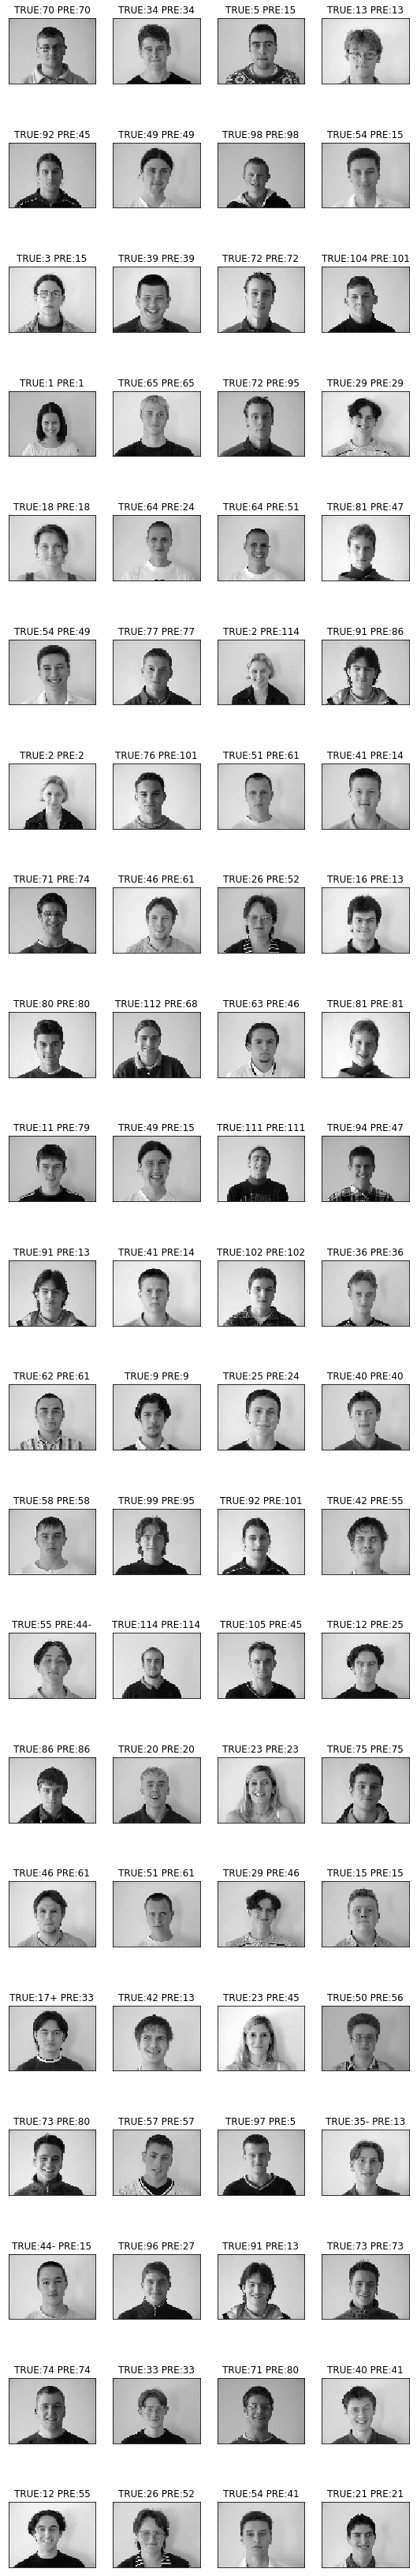

In [93]:
import matplotlib.pyplot as plt

def plot_gallery(images,h, w, n_row=21, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title("TRUE:"+Y1_test[i]+" "+"PRE:"+y_pred[i], size=12)
        plt.xticks(())
        plt.yticks(())        
plot_gallery(X1_test,h=height, w=width)

注：PCA降维结果一般，在图片像素为80 * 60 选取36个特征值，全部数据集15%test的比例下，识别率为33%，正脸图片25%test的比例下，识别率为37%

### （三）基于NMF的全部图片集

#### Step1：用NMF方法进行降维（进行特征抽取）

In [326]:
from sklearn import decomposition
import time
n_components = 36 ##同样抓取36个特征值
t0 = time.time()

nmf = decomposition.NMF(n_components=36, random_state=0).fit(X_train)
print("nmf done %0.3fs" % (time.time() - t0))

t0 = time.time()
X_train_nmf = nmf.transform(X_train)##得到nmf法后的X_train的特征值
X_test_nmf  = nmf.transform(X_test)##得到nmf法后的X_test的特征值
print("data set to nmf done %0.3fs" % (time.time() - t0))

nmf done 4.155s
data set to nmf done 0.343s


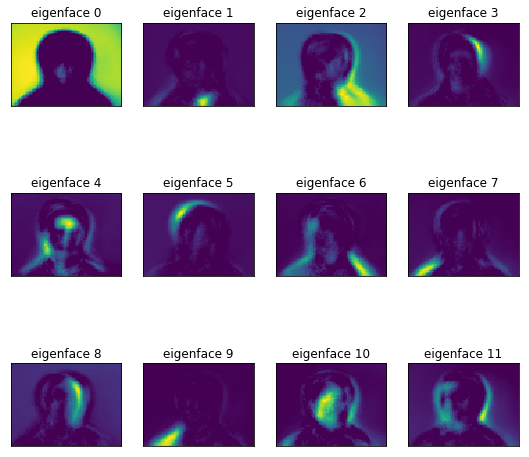

In [327]:
eigenfaces = nmf.components_.reshape((n_components, height, width))
eigenfaces.shape
def plot_gallery(images,titles,h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)))
        plt.title(titles[i], size=12)  
        plt.xticks(())
        plt.yticks(())
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]        
plot_gallery(eigenfaces,eigenface_titles,h=height, w=width)        

#### Step2：训练SVM分类器

In [328]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
# 构造分类器
t0 = time.time()
param_grid = {
    "C": [1e3, 5e3, 1e4, 1e5],
    "gamma": [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]
}
clf = GridSearchCV(svm.SVC(kernel='rbf', class_weight='balanced'), param_grid=param_grid)
clf.fit(X_train_nmf, Y_train)
print("fit done %0.3fs" % (time.time() - t0))
print(clf.best_estimator_)
print(clf.best_score_)

fit done 11.310s
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.18168389955686853


#### Step3：用训练出的模型对test部分进行预测

In [329]:
y_pred = clf.predict(X_test_nmf)
print(classification_report(Y_test, y_pred))
##效果不如PCA 只有27%的识别率（看f1-score的平均值）

             precision    recall  f1-score   support

          1       1.00      1.00      1.00         1
         10       0.00      0.00      0.00         0
        100       0.00      0.00      0.00         1
        101       0.00      0.00      0.00         0
        102       0.00      0.00      0.00         0
        103       1.00      1.00      1.00         2
        104       0.00      0.00      0.00         1
        105       0.00      0.00      0.00         1
        106       0.50      1.00      0.67         1
        107       0.00      0.00      0.00         2
        108       1.00      1.00      1.00         1
        109       0.00      0.00      0.00         1
         11       1.00      1.00      1.00         1
        110       0.00      0.00      0.00         1
        111       1.00      0.50      0.67         2
        113       0.00      0.00      0.00         1
        114       0.50      0.50      0.50         2
         12       0.00      0.00      0.00   

C:\Users\zhoumeng\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\zhoumeng\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### （四）基于NMF的正脸图片集

#### Step1：用NMF非负矩阵分解方法降维（进行特征抽取）

In [298]:
#只选用正面照片
n_components = 36##同样抓取36个特征值
t0 = time.time()
nmf = decomposition.NMF(n_components=36, random_state=0).fit(X_train)
print("nmf done %0.3fs" % (time.time() - t0))
t0 = time.time()
X1_train_nmf = nmf.transform(X1_train)
X1_test_nmf = nmf.transform(X1_test)
print("data set to nmf done %0.3fs" % (time.time() - t0))

nmf done 4.218s
data set to nmf done 0.125s


#### Step2：训练SVM分类器

In [299]:
# 构造分类器
t0 = time.time()
param_grid = {
    "C": [1e3, 5e3, 1e4, 1e5],
    "gamma": [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]
}

clf = GridSearchCV(svm.SVC(kernel='rbf', class_weight='balanced'), param_grid=param_grid)
clf.fit(X1_train_nmf, Y1_train)
print("fit done %0.3fs" % (time.time() - t0))
print(clf.best_estimator_)
print(clf.best_score_)

C:\Users\zhoumeng\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


fit done 3.183s
SVC(C=5000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.34523809523809523


#### Step3：用训练出的模型对test模型进行预测

In [300]:
y_pred = clf.predict(X1_test_nmf)
print(classification_report(Y1_test, y_pred))
##效果不如PCA 只有26%的识别率

             precision    recall  f1-score   support

          1       1.00      1.00      1.00         1
         10       0.00      0.00      0.00         0
        100       0.00      0.00      0.00         0
        101       0.00      0.00      0.00         0
        102       0.33      1.00      0.50         1
        104       0.00      0.00      0.00         1
        105       0.00      0.00      0.00         1
         11       0.00      0.00      0.00         1
        111       1.00      1.00      1.00         1
        112       0.00      0.00      0.00         1
        114       0.50      1.00      0.67         1
         12       0.00      0.00      0.00         2
         13       0.50      1.00      0.67         1
         15       0.25      1.00      0.40         1
         16       1.00      1.00      1.00         1
        17+       0.00      0.00      0.00         1
         18       0.00      0.00      0.00         1
         19       0.00      0.00      0.00   

C:\Users\zhoumeng\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\zhoumeng\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


#### Step4：结果可视化

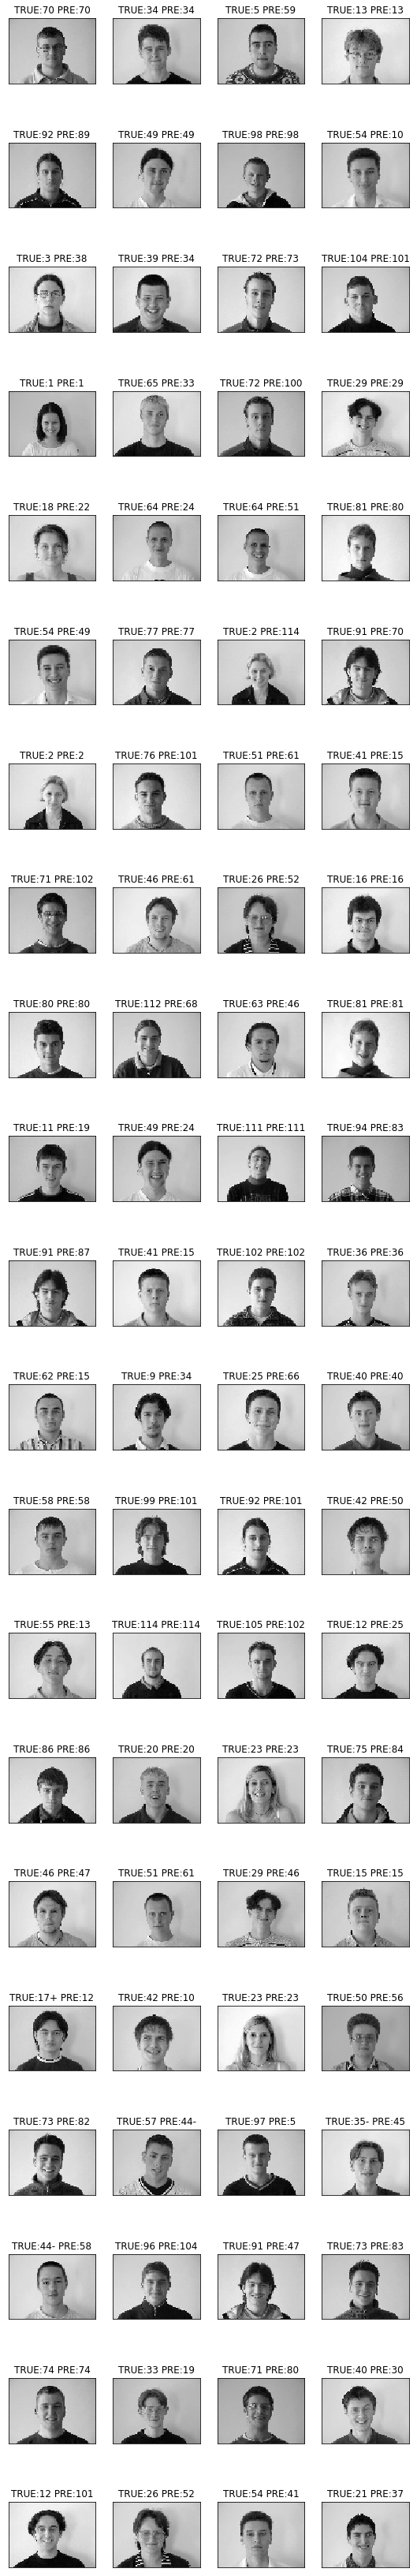

In [302]:
def plot_gallery(images,h, w, n_row=21, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title("TRUE:"+Y1_test[i]+" "+"PRE:"+y_pred[i], size=12)
        plt.xticks(())
        plt.yticks(())        
plot_gallery(X1_test,h=height, w=width)

注：NMF降维结果不好，在图片像素为80 * 60 选取36个特征值，全部数据集15%test的比例下，识别率为27%，正脸图片25%test的比例下，识别率为26%，在正脸图片集下的结果还不如总体图片集

### （五）基于LDA的全部图片集

#### Step1：X部分标准化（根据LDA方法的需要）

In [303]:
##全部数据集
##应为LDA需要的是标准化后的数据，所以将训练集和测试集中先进行标准化
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

#### Step2：用LDA方法降维（进行特征抓取）

In [304]:
##使用sklearn中的包进行LDA特征抓取
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
n_components = 36 ##降到36维
t0 = time.time()

lda = LDA(n_components=36).fit(X_train_std, Y_train)
print("nmf done %0.3fs" % (time.time() - t0))

t0 = time.time()
X_train_lda = lda.transform(X_train_std)
X_test_lda  = lda.transform(X_test_std)
print("data set to nmf done %0.3fs" % (time.time() - t0))

C:\Users\zhoumeng\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


nmf done 0.685s
data set to nmf done 0.031s


C:\Users\zhoumeng\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


#### Step3：训练SVM分类器

In [305]:
# 构造分类器
t0 = time.time()
param_grid = {
    "C": [1e3, 5e3, 1e4, 1e5],
    "gamma": [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]
}

clf = GridSearchCV(svm.SVC(kernel='rbf', class_weight='balanced'), param_grid=param_grid)
clf.fit(X_train_lda, Y_train)
print("fit done %0.3fs" % (time.time() - t0))
print(clf.best_estimator_)
print(clf.best_score_)

fit done 10.341s
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.8330871491875923


#### Step4：用训练出的模型对test部分进行预测

In [309]:
y_pred = clf.predict(X_test_lda)
print(classification_report(Y_test, y_pred))
##明显提升到了49%

             precision    recall  f1-score   support

          1       1.00      1.00      1.00         1
        100       0.00      0.00      0.00         1
        102       0.00      0.00      0.00         0
        103       1.00      0.50      0.67         2
        104       0.00      0.00      0.00         1
        105       0.00      0.00      0.00         1
        106       0.33      1.00      0.50         1
        107       0.50      0.50      0.50         2
        108       1.00      1.00      1.00         1
        109       0.00      0.00      0.00         1
         11       1.00      1.00      1.00         1
        110       1.00      1.00      1.00         1
        111       1.00      0.50      0.67         2
        112       0.00      0.00      0.00         0
        113       1.00      1.00      1.00         1
        114       1.00      1.00      1.00         2
         13       0.50      1.00      0.67         1
         14       0.00      0.00      0.00   

C:\Users\zhoumeng\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\zhoumeng\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### (六)基于LDA的正脸图片集

#### Step1：对X部分进进行标准化

In [312]:
##正脸数据集
##应为LDA需要的是标准化后的数据，所以将训练集和测试集中先进行标准化
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X1_train_std = sc.fit_transform(X1_train)
X1_test_std = sc.transform(X1_test)

#### Step2：用LDA方法降维（进行特征抽取）

In [313]:
##使用sklearn中的包进行LDA特征抓取
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
n_components = 36 ##降到36维
t0 = time.time()

lda = LDA(n_components=36).fit(X1_train_std, Y1_train)
print("lda done %0.3fs" % (time.time() - t0))

t0 = time.time()
X1_train_lda = lda.transform(X1_train_std)
X1_test_lda  = lda.transform(X1_test_std)
print("lda set to nmf done %0.3fs" % (time.time() - t0))

C:\Users\zhoumeng\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


lda done 0.270s
lda set to nmf done 0.016s


C:\Users\zhoumeng\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


#### Step3：训练SVM分类器

In [314]:
# 构造分类器
t0 = time.time()
param_grid = {
    "C": [1e3, 5e3, 1e4, 1e5],
    "gamma": [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]
}

clf = GridSearchCV(svm.SVC(kernel='rbf', class_weight='balanced'), param_grid=param_grid)
clf.fit(X1_train_lda, Y1_train)
print("fit done %0.3fs" % (time.time() - t0))
print(clf.best_estimator_)
print(clf.best_score_)

C:\Users\zhoumeng\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


fit done 3.077s
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.5079365079365079


#### Step4：用训练出的模型对test部分进行预测

In [315]:
y_pred = clf.predict(X1_test_lda)
print(classification_report(Y1_test, y_pred))
##明显提升到了51%

             precision    recall  f1-score   support

          1       1.00      1.00      1.00         1
         10       0.00      0.00      0.00         0
        101       0.00      0.00      0.00         0
        102       0.50      1.00      0.67         1
        104       0.00      0.00      0.00         1
        105       0.00      0.00      0.00         1
        106       0.00      0.00      0.00         0
         11       1.00      1.00      1.00         1
        111       1.00      1.00      1.00         1
        112       0.00      0.00      0.00         1
        114       1.00      1.00      1.00         1
         12       0.50      0.50      0.50         2
         13       0.25      1.00      0.40         1
         14       0.00      0.00      0.00         0
         15       0.25      1.00      0.40         1
         16       1.00      1.00      1.00         1
        17+       0.00      0.00      0.00         1
         18       1.00      1.00      1.00   

C:\Users\zhoumeng\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\zhoumeng\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


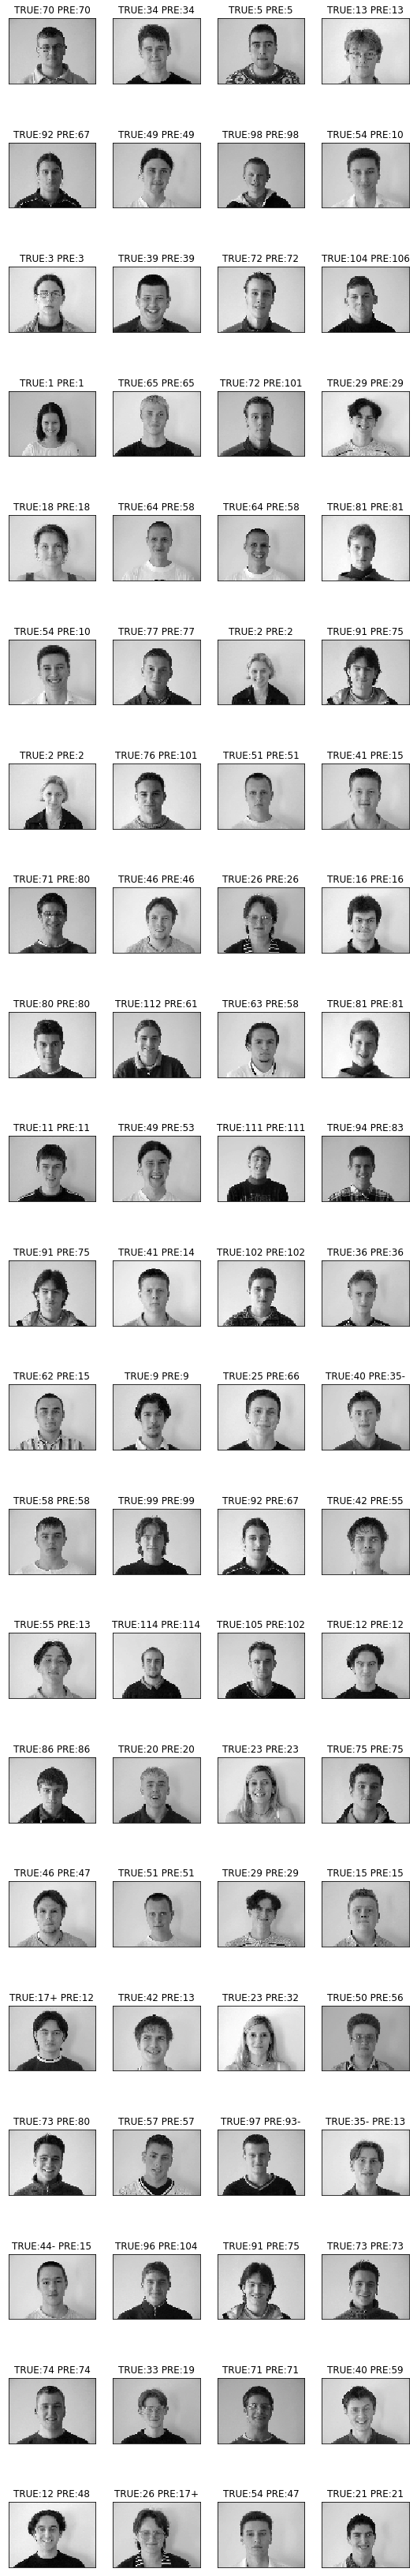

In [316]:
def plot_gallery(images,h, w, n_row=21, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title("TRUE:"+Y1_test[i]+" "+"PRE:"+y_pred[i], size=12)
        plt.xticks(())
        plt.yticks(())        
plot_gallery(X1_test,h=height, w=width)

注：LDA降维结果较好，在图片像素为80 * 60 选取36个特征值，全部数据集15%test的比例下，识别率为48%，正脸图片25%test的比例下，识别率为51%，是三个方法中识别率最高的一个